# 23 notebook #

In this notebook the model was trained using all available data instead of the average noise. The purpose of this experiment is to check whether the average noise cause the model bias.

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import numpy as np
import pandas as pd

from PIL import Image

from sklearn.model_selection import train_test_split

In [3]:
class ImageDataset(Dataset):
    def __init__(self, path: str, data: pd.DataFrame, transform=None) -> None:
        self.image_paths = np.array(
            [path + filename for filename in data["filename"].to_numpy()]
        )
        self.labels = data["epsilon"].to_numpy()
        self.transform = transform

    def __getitem__(self, inx: int) -> tuple:
        image_path = self.image_paths[inx]
        label_float_epsilon = self.labels[inx]
        target = np.zeros(shape=(1000,))
        target[int(label_float_epsilon * 1000)] = 1
        image = Image.open(image_path)
        image = np.array(image)
        # repeat grayscale value three times for all RGB channels
        image = np.repeat(image[..., np.newaxis], 3, -1)
        if self.transform:
            image = self.transform(image)
        return image, torch.from_numpy(target)

    def __len__(self) -> int:
        return len(self.image_paths)

In [4]:
transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)

In [5]:
avg_steel_df = pd.read_csv(
    "../data/generated/fourier/steel/freq/freq_single_parameters.csv", index_col=False
)
avg_steel_df["filename"] = "fourier/steel/freq/" + avg_steel_df["filename"].astype(str)

In [6]:
avg_steel_train, avg_steel_test = train_test_split(
    avg_steel_df,
    test_size=0.4,
    random_state=12,
    shuffle=True,
    stratify=avg_steel_df["epsilon"],
)
avg_steel_test, avg_steel_valid = train_test_split(
    avg_steel_test,
    test_size=1000,
    random_state=12,
    shuffle=True,
    stratify=avg_steel_test["epsilon"],
)

In [7]:
main_params_dir = "../data/generated/"
blackbox_csv = pd.read_csv(main_params_dir + "blackbox_train.csv", index_col=False)
blackbox_csv["filename"] = "blackbox/" + blackbox_csv["filename"].astype(str)
blackbox_train, blackbox_valid = train_test_split(
    blackbox_csv,
    test_size=1000,
    random_state=12,
    shuffle=True,
    stratify=blackbox_csv["epsilon"],
)

bubble_csv = pd.read_csv(main_params_dir + "bubble_train.csv", index_col=False)
bubble_csv["filename"] = "bubble/" + bubble_csv["filename"].astype(str)
bubble_train, bubble_valid = train_test_split(
    bubble_csv,
    test_size=1000,
    random_state=12,
    shuffle=True,
    stratify=bubble_csv["epsilon"],
)

pizza_csv = pd.read_csv(main_params_dir + "pizza_train.csv", index_col=False)
pizza_csv["filename"] = "pizza/" + pizza_csv["filename"].astype(str)
pizza_train, pizza_valid = train_test_split(
    pizza_csv,
    test_size=1000,
    random_state=12,
    shuffle=True,
    stratify=pizza_csv["epsilon"],
)

pure_csv = pd.read_csv(main_params_dir + "pure_train.csv", index_col=False)
pure_csv["filename"] = "pure/" + pure_csv["filename"].astype(str)
pure_train, pure_valid = train_test_split(
    pure_csv,
    test_size=1000,
    random_state=12,
    shuffle=True,
    stratify=pure_csv["epsilon"],
)


# laod test csv
blackbox_test = pd.read_csv(main_params_dir + "blackbox_test.csv", index_col=False)
blackbox_test["filename"] = "blackbox/" + blackbox_test["filename"].astype(str)

bubble_test = pd.read_csv(main_params_dir + "bubble_test.csv", index_col=False)
bubble_test["filename"] = "bubble/" + bubble_test["filename"].astype(str)

pizza_test = pd.read_csv(main_params_dir + "pizza_test.csv", index_col=False)
pizza_test["filename"] = "pizza/" + pizza_test["filename"].astype(str)

pure_test = pd.read_csv(main_params_dir + "pure_test.csv", index_col=False)
pure_test["filename"] = "pure/" + pure_test["filename"].astype(str)

In [8]:
DATASETS = {
    "average": {
        "train": avg_steel_train,
        "valid": avg_steel_valid,
        "test": avg_steel_test,
    },
    "blackbox": {
        "train": blackbox_train,
        "valid": blackbox_valid,
        "test": blackbox_test,
    },
    "bubble": {"train": bubble_train, "valid": bubble_valid, "test": bubble_test},
    "pizza": {"train": pizza_train, "valid": pizza_valid, "test": pizza_test},
    "pure": {"train": pure_train, "valid": pure_valid, "test": pure_test},
}

In [9]:
# combine all datasets
best_train = (
    pd.concat(
        [
            DATASETS["pure"]["train"],
            DATASETS["average"]["train"],
            DATASETS["blackbox"]["train"],
            DATASETS["bubble"]["train"],
            DATASETS["pizza"]["train"],
        ]
    )
    .sample(frac=1, random_state=12)
    .reset_index(drop=True)
)

best_valid = (
    pd.concat(
        [
            DATASETS["pure"]["valid"],
            DATASETS["average"]["valid"],
            DATASETS["blackbox"]["valid"],
            DATASETS["bubble"]["valid"],
            DATASETS["pizza"]["valid"],
        ]
    )
    .sample(frac=1, random_state=12)
    .reset_index(drop=True)
)

In [13]:
import torch.nn as nn
from torchvision import models
from tqdm import tqdm

In [11]:
main_dir = "../data/generated/"

train_dataset = ImageDataset(path=main_dir, parameters=best_train, transform=transform)
valid_dataset = ImageDataset(path=main_dir, parameters=best_valid, transform=transform)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=0)

In [14]:
device = "cuda" if torch.cuda.is_available else "cpu"
lr = 1e-4
epochs = 10
print(device)

cuda


In [15]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [19]:
model = models.resnet18(pretrained=True)

classifier = nn.Sequential(
    nn.Linear(512, 512), nn.ReLU(), nn.Dropout(0.3), nn.ReLU(), nn.Linear(512, 1000)
)

model.fc = classifier

In [20]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, eps=1e-8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=1, factor=0.9, min_lr=1e-5
)

In [21]:
min_valid_loss = np.inf
history = {"train_losses": [], "valid_losses": []}

model.cuda()

for epoch in range(epochs):
    model.train()
    train_batch_losses = []
    for data, labels in tqdm(train_loader):
        images = data.cuda()
        targets = labels.cuda()
        outputs = model(images)

        loss = loss_fn(outputs, targets)

        # optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_batch_losses.append(loss.item())
    train_loss = np.sum(train_batch_losses) / len(train_batch_losses)
    history["train_losses"].append(train_loss)

    model.eval()
    fin_targets = []
    fin_outputs = []
    valid_batch_losses = []
    with torch.no_grad():
        for data, labels in valid_loader:
            images = data.cuda()
            targets = labels.cuda()
            outputs = model(images)

            loss = loss_fn(outputs, targets)
            valid_batch_losses.append(loss.item())
        valid_loss = np.sum(valid_batch_losses) / len(valid_batch_losses)
        history["valid_losses"].append(valid_loss)

    if min_valid_loss > valid_loss:
        torch.save(model.state_dict(), "../models/23_notebook/best_steel_model.pth")
        min_valid_loss = valid_loss

    print(
        f"Epoch {epoch} \t\t Training Loss: {train_loss} \t\t Validation Loss: {valid_loss}"
    )
    scheduler.step(valid_loss)

    torch.save(model.state_dict(), "../models/23_notebook/final_steel_model.pth")

100%|██████████| 938/938 [03:03<00:00,  5.11it/s]


Epoch 0 		 Training Loss: 0.02647160002851769 		 Validation Loss: 0.007979093033786664


100%|██████████| 938/938 [03:03<00:00,  5.10it/s]


Epoch 1 		 Training Loss: 0.008316540460807527 		 Validation Loss: 0.007701982821551068


100%|██████████| 938/938 [03:02<00:00,  5.13it/s]


Epoch 2 		 Training Loss: 0.007187274138915821 		 Validation Loss: 0.005983365231488395


100%|██████████| 938/938 [03:01<00:00,  5.16it/s]


Epoch 3 		 Training Loss: 0.006100830863413172 		 Validation Loss: 0.005381390985766642


100%|██████████| 938/938 [03:01<00:00,  5.16it/s]


Epoch 4 		 Training Loss: 0.005554769723745125 		 Validation Loss: 0.004949772607079354


100%|██████████| 938/938 [03:01<00:00,  5.17it/s]


Epoch 5 		 Training Loss: 0.0051746180052256435 		 Validation Loss: 0.004701416040146206


100%|██████████| 938/938 [03:01<00:00,  5.16it/s]


Epoch 6 		 Training Loss: 0.004879905264932869 		 Validation Loss: 0.0044821318403475184


100%|██████████| 938/938 [03:01<00:00,  5.17it/s]


Epoch 7 		 Training Loss: 0.0046336919227816355 		 Validation Loss: 0.00425305240745978


100%|██████████| 938/938 [03:32<00:00,  4.41it/s]


Epoch 8 		 Training Loss: 0.004431639116106855 		 Validation Loss: 0.004115028549282408


100%|██████████| 938/938 [03:03<00:00,  5.11it/s]


Epoch 9 		 Training Loss: 0.0042639081657987275 		 Validation Loss: 0.003995428523999551


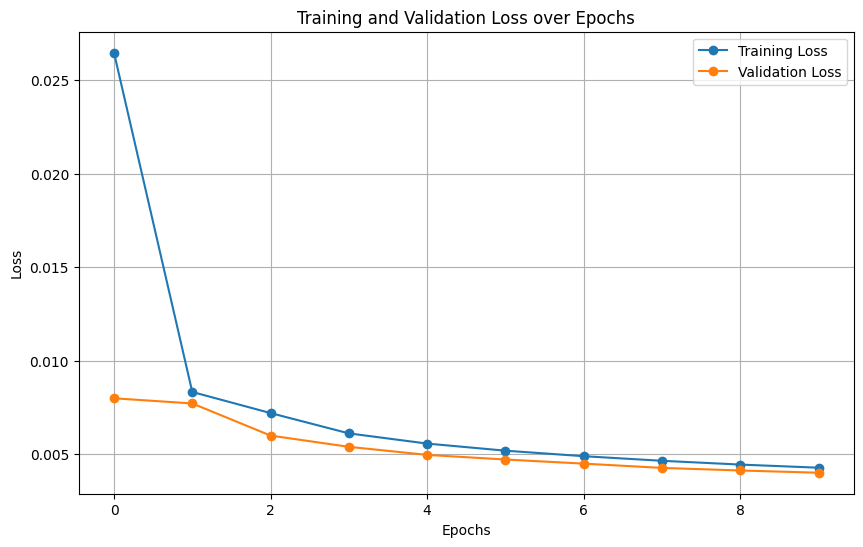

In [22]:
import matplotlib.pyplot as plt

# Extracted data from the logs
epochs = list(range(10))
training_loss = history["train_losses"]

validation_loss = history["valid_losses"]

# Plotting the loss curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label="Training Loss", marker="o")
plt.plot(epochs, validation_loss, label="Validation Loss", marker="o")
plt.title("Training and Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

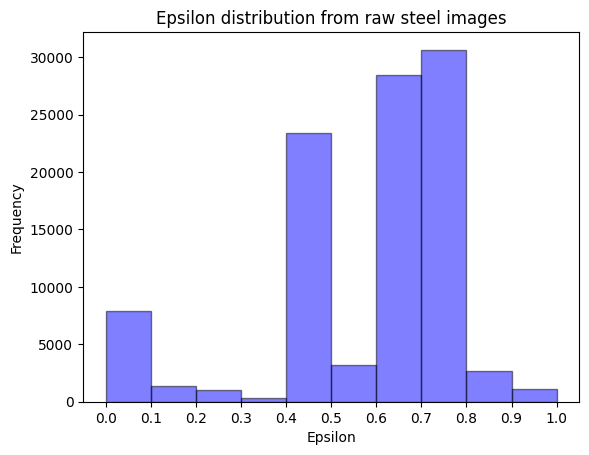

In [23]:
steel = pd.read_csv("../data/results/23_notebook/best_steel_model.csv")
plt.hist(
    steel["epsilon"], bins=10, range=(0, 1), color="blue", alpha=0.5, edgecolor="black"
)
plt.title("Epsilon distribution from raw steel images")
plt.xlabel("Epsilon")
plt.ylabel("Frequency")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()